# K-MEANS CLUSTERING FROM SCRATCH

## INTRODUCTION & OBJECTIVES

IN THIS PROJECT, WE IMPLEMENT THE **K-MEANS CLUSTERING ALGORITHM** ENTIRELY FROM FIRST PRINCIPLES. WE WILL NOT USE `SCIKIT-LEARN` OR ANY BLACK-BOX CLUSTERING UTILITIES. THE GOAL IS TO DEMONSTRATE A DEEP MATHEMATICAL AND ALGORITHMIC UNDERSTANDING OF UNSUPERVISED LEARNING.

### CORE OBJECTIVES
* **MATHEMATICAL RIGOR**: IMPLEMENT EUCLIDEAN, MANHATTAN, AND COSINE DISTANCE METRICS FROM SCRATCH.
* **MODULAR ARCHITECTURE**: DESIGN A ROBUST `KMEANS` CLASS WITH EXPLICIT HYPERPARAMETERS.
* **OPTIMIZATION LOGIC**: IMPLEMENT THE ITERATIVE EXPECTATION-MAXIMIZATION (E-M) LOOP MANUALLY.
* **CONVERGENCE ANALYSIS**: VISUALIZE LOSS CURVES AND CENTROID STABILITY.

### RESTRICTIONS
* **NO SCIKIT-LEARN**.
* **ONLY NUMPY, PANDAS, MATPLOTLIB, SEABORN**.
* **MANUAL SCALING AND CALCULATIONS**.

## IMPORTS & SETUP

### LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### VISUALIZATION CONFIGURATION

In [3]:
# SETTING GLOBAL PARAMS TO ENSURE ALL PLOTS FOLLOW THE REQUIRED STYLE
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

def enforce_bold_ticks(ax):
    """
    HELPER FUNCTION TO ENSURE TICKS ARE BOLD.
    """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

print("LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.")

LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.


## DATA LOADING AND EXPLORATION

WE LOAD THE `DATA.CSV` FILE CONTAINING OUR 2D DATASET.  
PRELIMINARY VISUALIZATION IS CRUCIAL TO UNDERSTAND THE CLUSTERING TENDENCY OF THE DATA.

In [18]:
# LOAD DATASET
FILE_PATH = 'DATA/DATA.csv'
df = pd.read_csv(FILE_PATH)

In [19]:
# INSPECT DATA STRUCTURE
print("DATA HEAD:")
print(df.head())
print("\nDATA DESCRIPTION:")
print(df.describe())

DATA HEAD:
       x1      x2
0  24.412  32.932
1  35.190  12.189
2  26.288  41.718
3   0.376  15.506
4  26.116   3.963

DATA DESCRIPTION:
              x1         x2
count  60.000000  60.000000
mean   23.568933  23.684633
std    11.203285  13.564296
min    -0.684000   3.412000
25%    19.903750  12.919500
50%    26.202000  19.457500
75%    32.269750  36.312000
max    39.634000  47.693000


In [20]:
# EXTRACT FEATURES AS NUMPY ARRAY
X_raw = df[['x1', 'x2']].values

### VISUALIZE RAW DATA

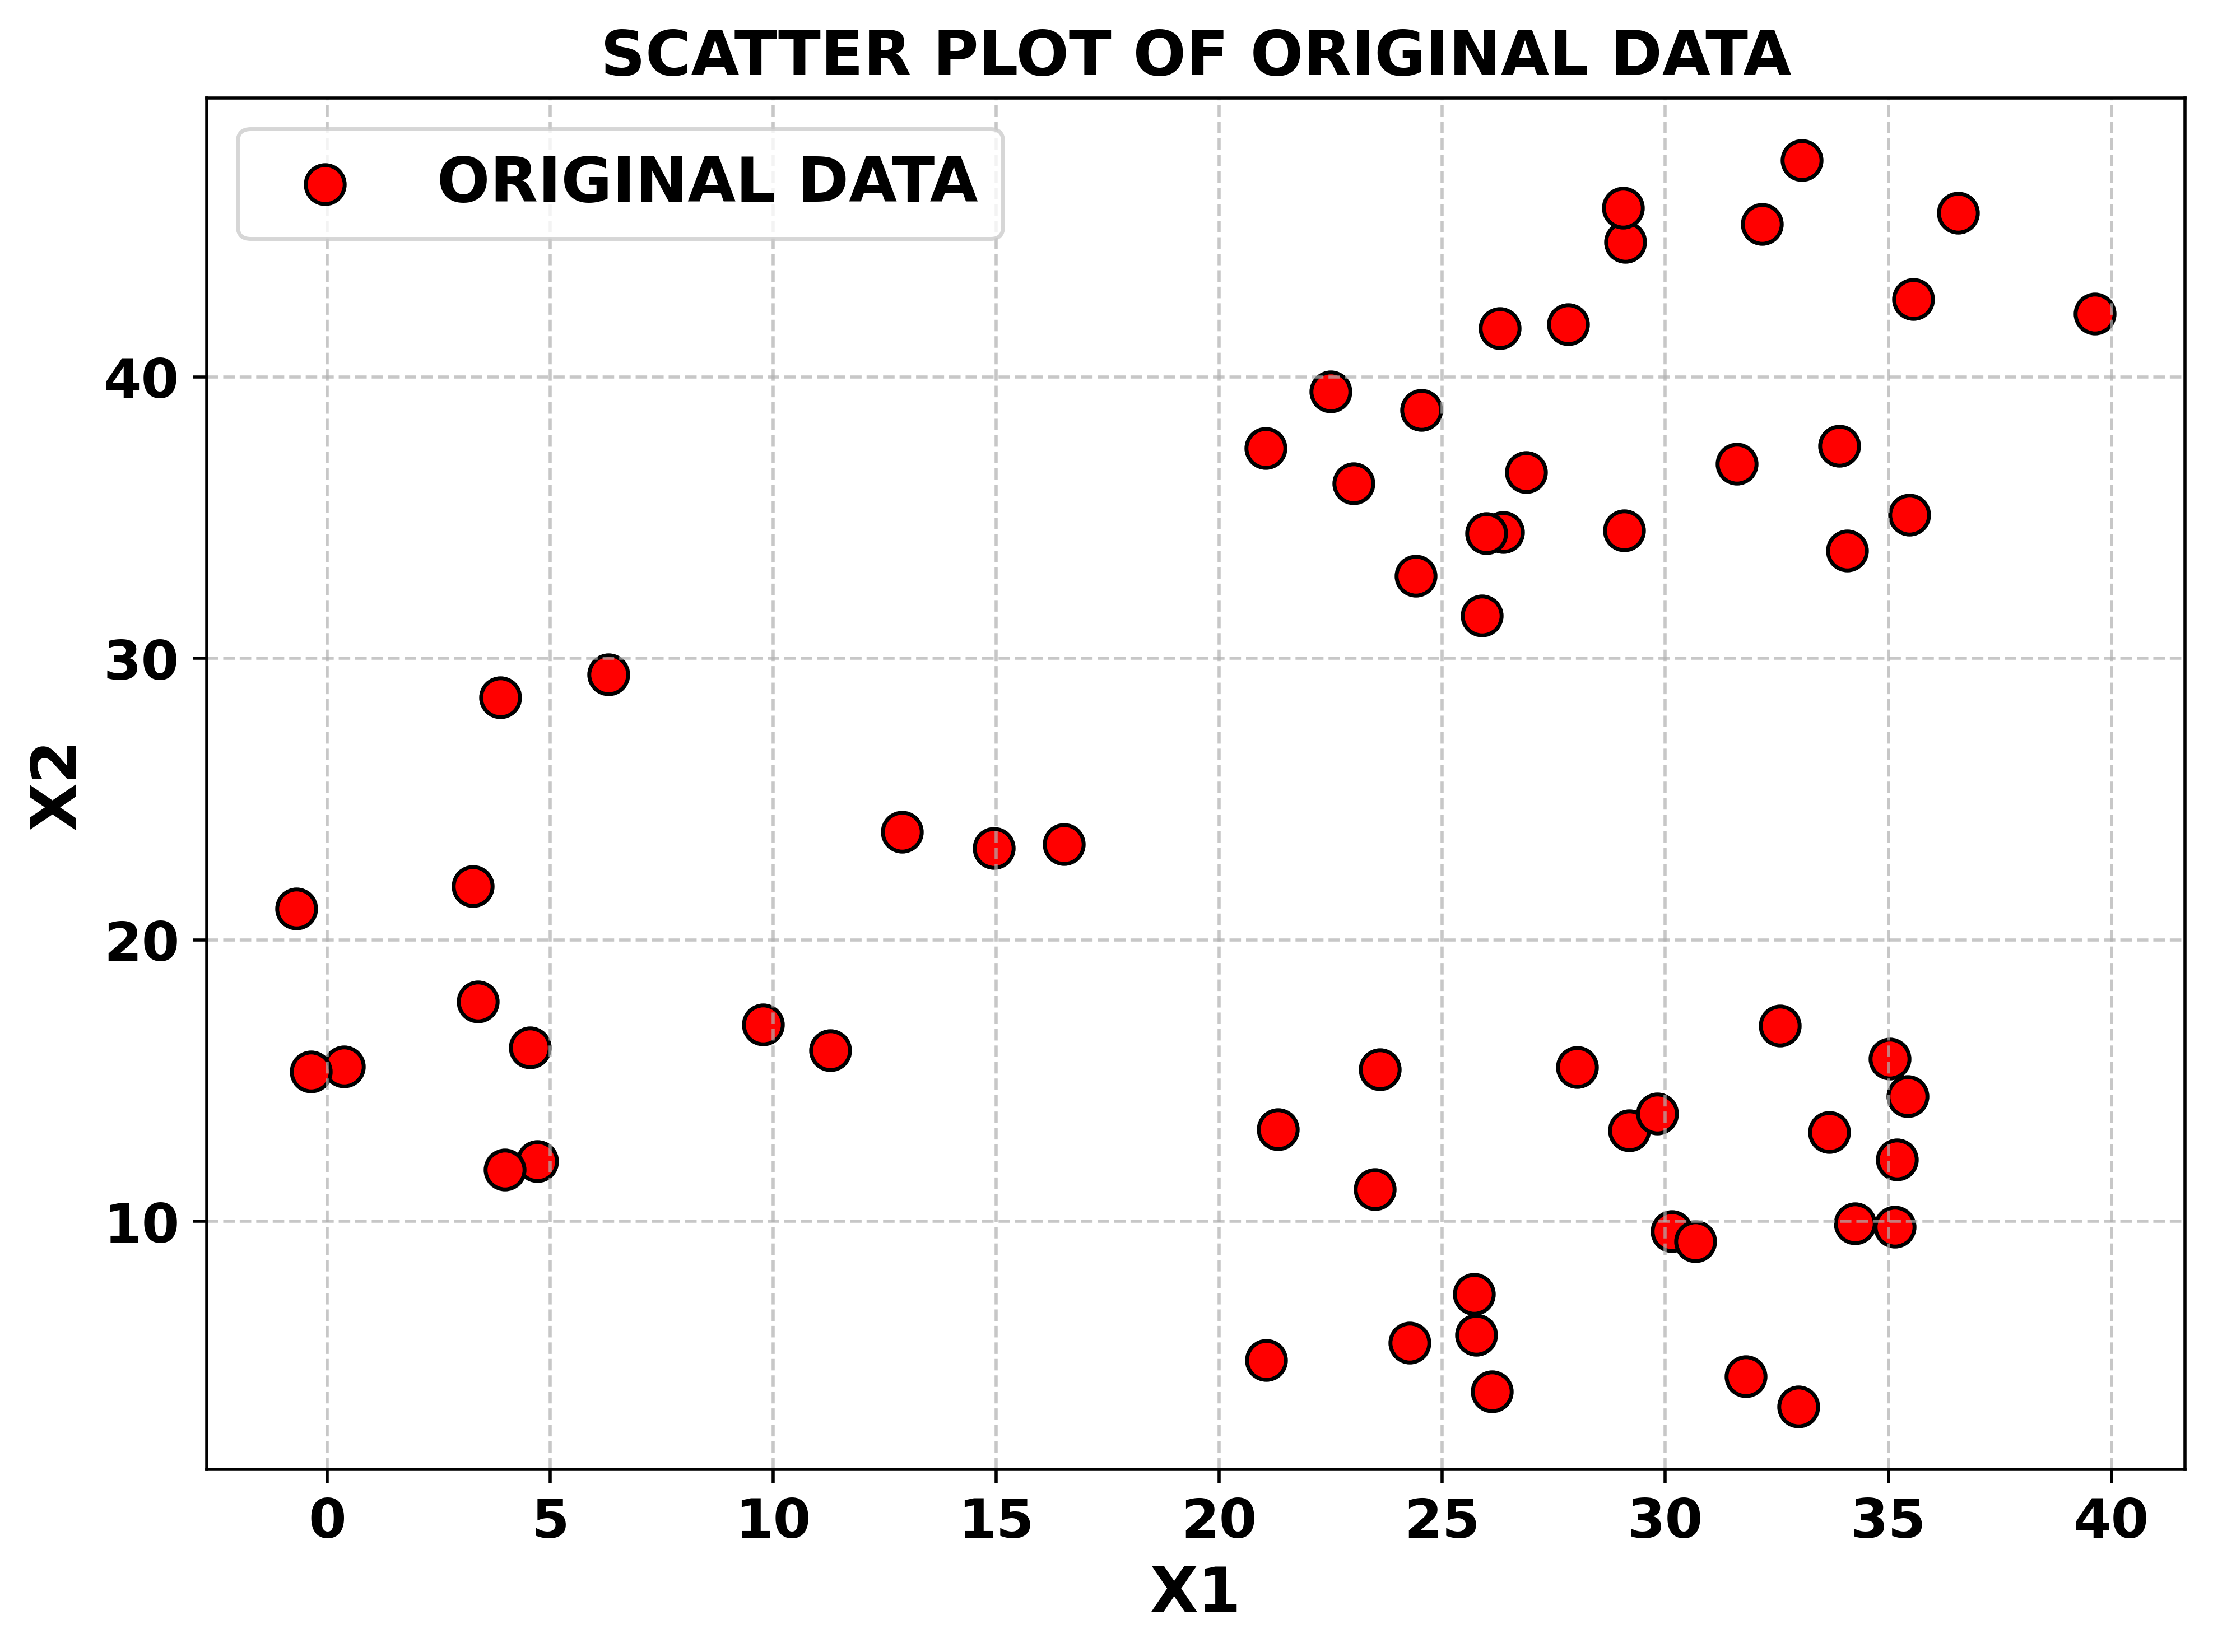

In [21]:
# VISUALIZE ORIGINAL DATA
plt.figure(figsize=(8, 6), dpi=500)
plt.scatter(X_raw[:, 0], X_raw[:, 1], color='red', edgecolor='black', s=100, label="ORIGINAL DATA")

plt.title("SCATTER PLOT OF ORIGINAL DATA")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper left', frameon=True)

enforce_bold_ticks(plt.gca())
plt.tight_layout()
plt.show()

## DATA PREPROCESSING

K-MEANS IS A DISTANCE-BASED ALGORITHM. FEATURES WITH LARGER MAGNITUDES CAN DISPROPORTIONATELY INFLUENCE THE DISTANCE CALCULATIONS. 

TO PREVENT THIS, WE IMPLEMENT **Z-SCORE NORMALIZATION** MANUALLY.

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

WHERE $\mu$ IS THE MEAN AND $\sigma$ IS THE STANDARD DEVIATION.

In [22]:
class StandardScaler:
    """
    IMPLEMENTS Z-SCORE NORMALIZATION.
    """
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        """
        COMPUTES MEAN AND STD, THEN SCALES THE DATA.
        """
        
        # CALCULATE MEAN AND STD ALONG AXIS 0 (COLUMNS)
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        
        # PREVENT DIVISION BY ZERO
        self.std[self.std == 0] = 1.0
        
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X_scaled):
        """
        REVERTS SCALING TO ORIGINAL SPACE FOR VISUALIZATION.
        """
        
        return (X_scaled * self.std) + self.mean

In [34]:
# APPLY SCALING

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"RAW DATA MEAN: {np.mean(X_raw, axis=0)}")
print(f"SCALED DATA MEAN (APPROX 0): {np.mean(X_scaled, axis=0)}")
print('-' * 63)
print(f"RAW DATA STD: {np.std(X_raw, axis=0)}")
print(f"SCALED DATA STD (APPROX 1): {np.std(X_scaled, axis=0)}")

RAW DATA MEAN: [23.56893333 23.68463333]
SCALED DATA MEAN (APPROX 0): [-4.81096644e-17  2.16493490e-16]
---------------------------------------------------------------
RAW DATA STD: [11.10953171 13.45078476]
SCALED DATA STD (APPROX 1): [1. 1.]


# WHY Z-SCORE (STANDARDIZATION) INSTEAD OF MIN-MAX SCALING?

IN THIS IMPLEMENTATION, WE CHOSE **Z-SCORE NORMALIZATION** (STANDARDIZATION) OVER **MIN-MAX SCALING**. 

BELOW IS THE MATHEMATICAL AND PRACTICAL JUSTIFICATION FOR THIS DECISION IN THE CONTEXT OF K-MEANS CLUSTERING.

## 1. SENSITIVITY TO OUTLIERS

### THE PROBLEM WITH MIN-MAX
MIN-MAX SCALING TRANSFORMS DATA INTO A BOUNDED RANGE, TYPICALLY $[0, 1]$, USING THE FORMULA:
$$x' = \frac{x - \min(x)}{\max(x) - \min(x)}$$
IF THE DATASET CONTAINS EVEN A SINGLE EXTREME OUTLIER, THE DENOMINATOR $(\max(x) - \min(x))$ BECOMES VERY LARGE. THIS CAUSES THE MAJORITY OF THE "NORMAL" DATA POINTS TO BE SQUASHED INTO A TINY INTERVAL, EFFECTIVELY REMOVING VARIANCE INFORMATION THAT K-MEANS NEEDS TO DISTINGUISH CLUSTERS.

### THE Z-SCORE ADVANTAGE
Z-SCORE SCALING USES MEAN AND STANDARD DEVIATION:
$$z = \frac{x - \mu}{\sigma}$$
WHILE OUTLIERS DO AFFECT THE MEAN AND STANDARD DEVIATION, THEY DO NOT DEFINE THE HARD BOUNDARIES OF THE SCALE. Z-SCORE SCALING IS MORE ROBUST BECAUSE IT SCALES DATA BASED ON THE DISTRIBUTION'S SPREAD (VARIANCE) RATHER THAN ITS ABSOLUTE LIMITS.

## 2. ISOTROPIC VARIANCE ASSUMPTION

K-MEANS (WITH EUCLIDEAN DISTANCE) ASSUMES THAT CLUSTERS ARE SPHERICAL AND HAVE SIMILAR VARIANCE.
* **Z-SCORE** CENTERS THE DATA AT 0 AND SCALES IT TO HAVE UNIT VARIANCE ($\sigma=1$). THIS ALIGNS PERFECTLY WITH THE ALGORITHM'S ASSUMPTION, ENSURING THAT THE DISTANCE METRIC TREATS ALL DIMENSIONS EQUALLY IN TERMS OF STATISTICAL SPREAD.
* **MIN-MAX** DOES NOT GUARANTEE UNIT VARIANCE. ONE FEATURE COULD BE UNIFORMLY DISTRIBUTED OVER $[0,1]$ WHILE ANOTHER IS NORMALLY DISTRIBUTED AND CENTERED AT 0.5 WITH SMALL VARIANCE. K-MEANS MIGHT INCORRECTLY WEIGHT THESE FEATURES.

## 3. HANDLING UNSEEN DATA

IN A PRODUCTION SETTING, WE OFTEN FIT A MODEL ON TRAINING DATA AND PREDICT ON NEW DATA.
* **MIN-MAX SCALING**: IF A NEW DATA POINT FALLS OUTSIDE THE ORIGINAL $[\min, \max]$ RANGE, IT WILL BE SCALED TO A VALUE `< 0` OR `> 1`, POTENTIALLY BREAKING ASSUMPTIONS OR REQUIRING CONSTANT RE-CALCULATION OF BOUNDARIES.
* **Z-SCORE**: NEW DATA SIMPLY DEVIATES MORE FROM THE MEAN (E.G., A Z-SCORE OF 5.0). THIS IS MATHEMATICALLY CONSISTENT AND DOES NOT REQUIRE KNOWING THE ABSOLUTE GLOBAL MINIMUM OR MAXIMUM IN ADVANCE.

## CONCLUSION
WE USE Z-SCORE SCALING BECAUSE IT IS **LESS SENSITIVE TO OUTLIERS** AND **BETTER PRESERVES THE STATISTICAL PROPERTIES** REQUIRED FOR DISTANCE-BASED ALGORITHMS LIKE K-MEANS TO FUNCTION OPTIMALLY.